In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py

import os
from dotenv import load_dotenv
load_dotenv()

from data_manipulation.reading_util import filter_unwanted_seqs

2023-08-27 13:20:25.249996: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-27 13:20:25.411703: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-27 13:20:25.412982: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-27 13:20:26.312096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Reading in esm2 embeddings

In [2]:
def read_data(path_to_enzyme_esm2: str, path_to_enzyme_splitX_csv: str):
    """
    Reads in esm2 and splitX.csv
    :param path_to_enzyme_esm2: Absolute path to enzyme_esm2_splitX
    :param path_to_enzyme_splitX_csv: Absolute path to enzyme_splitX.csv
    :return: A dataframe (representing splitX.csv), headers of esm2 (list), esm2 embeddings (list)
    """

    headers = []
    embeddings = []

    with h5py.File(path_to_enzyme_esm2) as hdf_handle:
        for header, emb in hdf_handle.items():
            headers.append(header)
            embeddings.append(np.array(list(emb)))
    print("LOG: ESM2 DONE")
    
    enzyme_csv = pd.read_csv(path_to_enzyme_splitX_csv, header=0, sep=',')
    print("LOG: CSV DONE")
    print("Enzymes in SplitX.csv:", len(enzyme_csv))
    
    # TODO: Inorder to apply this line of code, I also have to find the corresponding embeddings and 
    #  drop these as well...
    # enzyme_csv = filter_unwanted_seqs(enzyme_csv, True)

    # control
    print("Embeddings:", len(embeddings))
    print("Embedding headers:", len(headers))

    return[enzyme_csv, headers, embeddings]

def add_labels(enzymes: pd.DataFrame, entry_ids: list, esm2_emb: list):
    """
    Takes in the output of read_data(), grabs the corresponding ec number out of splitX.csv (enzymes) and adds this label 
    to our esm2 embeddings
    :param enzymes: Dataframe of splitX.csv
    :param entry_ids: Headers of esm2 emeddings
    :param esm2_emb: Embeddings
    :return: A list containing tupels of (header, label, embedding)
    """

    header_labels = {} # dict with → header(id): label (1-7)
    missing_headers = set() # set containing missing headers

    header_to_ec_mapping = {}
    for entry, ec_number in zip(enzymes["Entry"], enzymes["EC number"]):
        header_to_ec_mapping[entry] = ec_number[0]  # Extract the first character

    for header in entry_ids:
        number = enzymes.loc[enzymes["Entry"] == header,"EC number"]
        try:
            ec = int(number.iat[0][0])-1 # since we always start counting from 0
            header_labels[header] = ec
        except IndexError:
            missing_headers.add(header)

    header_label_tuples = [(header, header_labels[header]) for header in entry_ids if header not in missing_headers]

    # Create a new list of embeddings with labels
    embeddings_with_labels = []

    for header, emb in zip(entry_ids, esm2_emb):
        curr_label = next((label for h, label in header_label_tuples if h == header), None)
        if curr_label is not None:
            embeddings_with_labels.append((header, curr_label, emb))

    return embeddings_with_labels


# def get_ec_labels(path_to_enzyme_esm2: str, path_to_enzyme_splitX_csv) -> pd.DataFrame:
#     """
#     Adds a label representing the first main ec class (1-7) based on the ec number
#     :return: A dataframe containing the corresponding labels
#     """
# 
#     headers = []
#     embeddings = []
# 
#     with h5py.File(path_to_enzyme_esm2) as hdf_handle:
#         for header, emb in hdf_handle.items():
#             headers.append(header)
#             embeddings.append(np.array(list(emb)))
#     print("LOG: ESM2 DONE")
# 
#     enzyme_csv = pd.read_csv(path_to_enzyme_splitX_csv, header=0, sep=',')
#     
#     print("LOG: CSV DONE")
#     # TODO: Inorder to apply this line of code, I also have to find the corresponding embeddings and 
#     #  drop these as well...
#     # enzyme_csv = filter_unwanted_seqs(enzyme_csv, True)
# 
#     print(len(embeddings))
#     print(len(enzyme_csv))
#     print(len(headers))
# 
#     header_labels = {} # dict with → header(id): label (1-7)
#     missing_headers = set() # set containing missing headers
# 
#     header_to_ec_mapping = {}
#     for entry, ec_number in zip(enzyme_csv["Entry"], enzyme_csv["EC number"]):
#         header_to_ec_mapping[entry] = ec_number[0]  # Extract the first character
# 
#     for header in headers:
#         number = enzyme_csv.loc[enzyme_csv["Entry"] == header,"EC number"]
#         try:
#             ec = int(number.iat[0][0])-1 # since we always start counting from 0
#             header_labels[header] = ec
#         except IndexError:
#             missing_headers.add(header)
# 
#     header_label_tuples = [(header, header_labels[header]) for header in headers if header not in missing_headers]
# 
#     # Create a new list of embeddings with labels
#     embeddings_with_labels = []
# 
#     for header, emb in zip(headers, embeddings):
#         curr_label = next((label for h, label in header_label_tuples if h == header), None)
#         if curr_label is not None:
#             embeddings_with_labels.append((header, curr_label, emb))
# 
#     return embeddings_with_labels


### Creating X and y
#### Reading in data (splitX.csv and esm2_splitX)

In [3]:
enzyme_csv_path = os.getenv("CSV70_ENZYMES")
esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_70")
data = read_data(path_to_enzyme_splitX_csv=enzyme_csv_path, path_to_enzyme_esm2=esm2_enzymes_path)
enzyme_csv = data[0]
entry_ids = data[1]
embeddings = data[2]

LOG: ESM2 DONE
LOG: CSV DONE
Embeddings: 73553
Embedding headers: 73553
Enzymes in SplitX.csv: 73553


#### Now we add the corresponding labels

In [4]:
embedding_labels = add_labels(enzyme_csv, entry_ids, embeddings)

# embedding_labels = get_ec_labels(path_to_enzyme_splitX_csv=enzyme_csv_path, path_to_enzyme_esm2=esm2_enzymes_path)
X = []
y = []

for label in embedding_labels:
    y.append(label[1]) # append label (1-7)
    X.append(label[2]) # append embedding


### Control

73553
73553


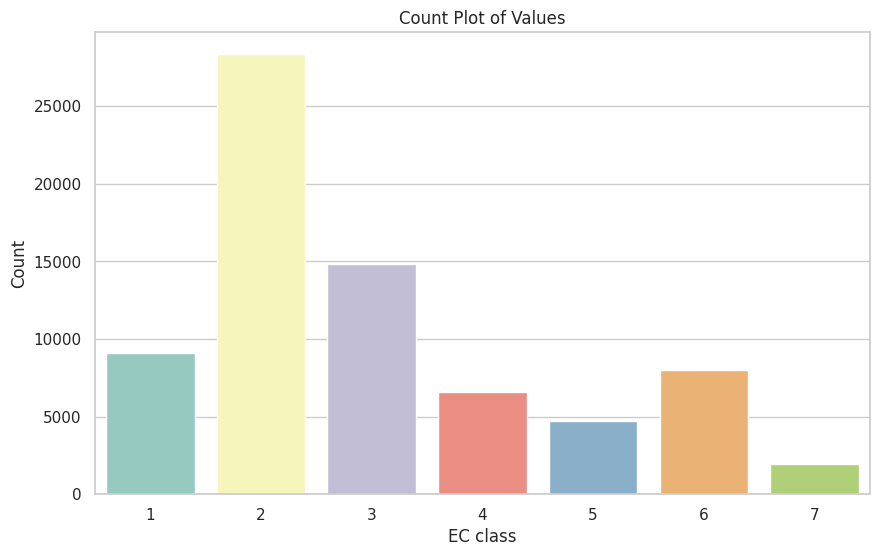

In [5]:
print(len(X))
print(len(y))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y, palette="Set3")
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])

# Add labels and title
plt.xlabel("EC class")
plt.ylabel("Count")
plt.title("Count Plot of Values")

# Show the plot
plt.show()

### Now we create a data frame with 2561 columns (one column for each feature and one for y label)

In [6]:
# Create a DataFrame
df = pd.DataFrame({"feature1":X, "label":y})

# Convert the lists in 'feature1' into separate columns using pd.DataFrame constructor
feature_columns = pd.DataFrame(df["feature1"].tolist(), columns=[f"feature_{i+1}" for i in range(2560)])

# Concatenate the feature columns with the original DataFrame
df = pd.concat([df.drop("feature1", axis=1), feature_columns], axis=1)

# Display the resulting DataFrame
print(df.head())


   label  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0      2  -0.062921  -0.092207  -0.001200   0.014007   0.005149   0.053362   
1      0  -0.053399   0.026311   0.068040  -0.047504  -0.056120   0.021154   
2      2  -0.015143   0.035552  -0.022313   0.002838  -0.011048  -0.017585   
3      2  -0.061284   0.034236  -0.034158  -0.106900  -0.030302  -0.071545   
4      0   0.059097  -0.034141   0.061427   0.006349  -0.058036  -0.020592   

   feature_7  feature_8  feature_9  ...  feature_2551  feature_2552  \
0  -0.016877   0.105275  -0.002420  ...      0.026946     -0.044988   
1  -0.073030   0.139663   0.022752  ...      0.032434     -0.056128   
2  -0.095678   0.095675   0.048721  ...     -0.021529     -0.027920   
3  -0.067266   0.009058   0.049455  ...      0.084735     -0.049660   
4  -0.064093   0.100111   0.019740  ...      0.089701     -0.076780   

   feature_2553  feature_2554  feature_2555  feature_2556  feature_2557  \
0      0.028635      0.025759

In [7]:
# df.to_csv("/home/malte/Desktop/ann_esm2_ml_df.csv", sep=";") # save csv for later use

### Now we extract data for X and y

In [8]:
X = df.drop('label', axis=1).values
y = df['label'].values

### Splitting data into train and test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
# Our labels need to be one hot encoded
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7) 
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)
print(y_test_encoded[0])

[0. 0. 0. 0. 1. 0. 0.]


## Creating our CNN

In [10]:
# This is used for stopping the training precess in advance, if our model starts to overfit our training data
earl_stop = tf.keras.callbacks.EarlyStopping(patience=15)

In [11]:
# Initializing the model
model = tf.keras.models.Sequential()

# Adding input layer
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))

# Adding hidden layer
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))

# Finally adding output layer using softmax as activation function
model.add(tf.keras.layers.Dense(units=7, activation='softmax'))  # Using softmax for multi-class classification

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [12]:
# Training the model
model.fit(x=X_train, y=y_train_encoded, epochs=100, validation_data=(X_test, y_test_encoded), callbacks = [earl_stop])

Epoch 1/100
1609/1609 [==============================] - 19s 12ms/step - loss: 0.7482 - val_loss: 0.2588
Epoch 2/100
1609/1609 [==============================] - 18s 11ms/step - loss: 0.3264 - val_loss: 0.1697
Epoch 3/100
1609/1609 [==============================] - 18s 11ms/step - loss: 0.2645 - val_loss: 0.1412
Epoch 4/100
1609/1609 [==============================] - 18s 11ms/step - loss: 0.2206 - val_loss: 0.1139
Epoch 5/100
1609/1609 [==============================] - 18s 11ms/step - loss: 0.2005 - val_loss: 0.1291
Epoch 6/100
1609/1609 [==============================] - 18s 11ms/step - loss: 0.1775 - val_loss: 0.1047
Epoch 7/100
1609/1609 [==============================] - 18s 11ms/step - loss: 0.1677 - val_loss: 0.1193
Epoch 8/100
1609/1609 [==============================] - 18s 11ms/step - loss: 0.1576 - val_loss: 0.0971
Epoch 9/100
1609/1609 [==============================] - 18s 11ms/step - loss: 0.1500 - val_loss: 0.0997
Epoch 10/100
1609/1609 [==============================]

# Evaluation

Text(0, 0.5, 'Loss')

<Figure size 1000x600 with 0 Axes>

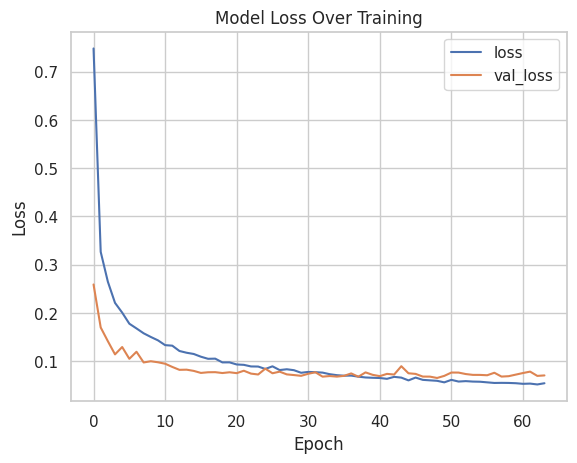

In [13]:
# Plotting loss (loss on train_data) and val_loss (loss on validation_data)
model_loss = pd.DataFrame(model.history.history)

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
model_loss.plot()

plt.title('Model Loss Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [14]:
predictions = np.argmax(model.predict(X_test), axis=-1) # for multi class classification (using softmax)

690/690 [==============================] - 2s 2ms/step


In [15]:
counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print("Correct predictions: ", counter)
print("Total samples predicted:", len(y_test))

Correct predictions:  21765
Total samples predicted: 22066


In [16]:
report = classification_report(y_test, predictions)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2689
           1       0.99      0.99      0.99      8548
           2       0.98      0.99      0.99      4467
           3       0.97      0.96      0.97      1961
           4       0.98      0.98      0.98      1390
           5       1.00      0.99      1.00      2457
           6       0.99      0.98      0.98       554

    accuracy                           0.99     22066
   macro avg       0.99      0.98      0.98     22066
weighted avg       0.99      0.99      0.99     22066


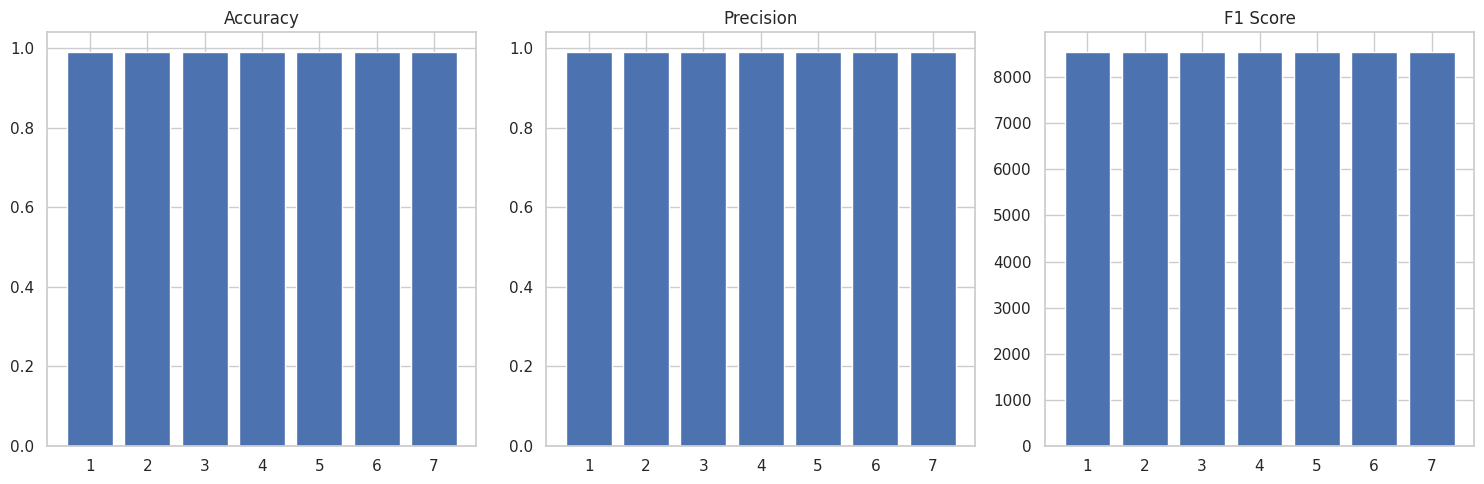

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2689
           1       0.99      0.99      0.99      8548
           2       0.98      0.99      0.99      4467
           3       0.97      0.96      0.97      1961
           4       0.98      0.98      0.98      1390
           5       1.00      0.99      1.00      2457
           6       0.99      0.98      0.98       554

    accuracy                           0.99     22066
   macro avg       0.99      0.98      0.98     22066
weighted avg       0.99      0.99      0.99     22066


In [21]:
class_0_metrics = report.split('\n')[3].split()[1:]
class_1_metrics = report.split('\n')[4].split()[1:]
class_2_metrics = report.split('\n')[5].split()[1:]
class_3_metrics = report.split('\n')[6].split()[1:]
class_4_metrics = report.split('\n')[7].split()[1:]
class_5_metrics = report.split('\n')[8].split()[1:]
class_6_metrics = report.split('\n')[9].split()[1:]

metrics = [class_0_metrics,
           class_1_metrics,
           class_2_metrics,
           class_3_metrics,
           class_4_metrics,
           class_5_metrics,
           class_6_metrics
           ]
i = 1
accs = []
precs = []
f1_s = []
for class_m in metrics:
    accuracy = float(class_0_metrics[0])
    precision = float(class_0_metrics[1])
    recall = float(class_0_metrics[2])
    f1_score = float(class_0_metrics[3])
    accs.append(accuracy)
    precs.append(precision)
    f1_s.append(f1_score)
    i+=1

class_names = [1,2,3,4,5,6,7]

# Create subplots for accuracy, precision, and F1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Plot accuracy for each class
ax1.bar(class_names, accs)
ax1.set_title("Accuracy")

# Plot precision for each class
ax2.bar(class_names, precs)
ax2.set_title("Precision")

# Plot F1 score for each class
ax3.bar(class_names, f1_s)
ax3.set_title("F1 Score")

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

print(report)

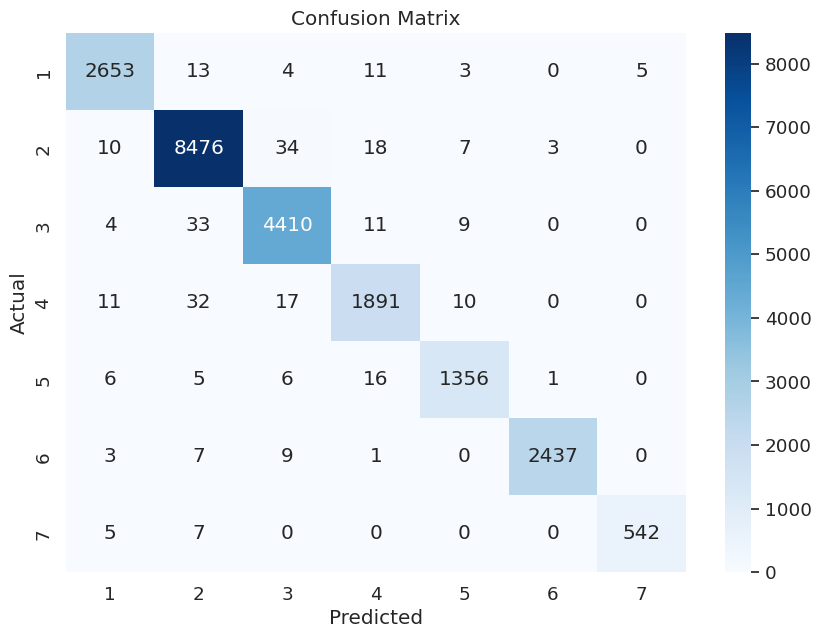

In [23]:
conf_matrix = confusion_matrix(y_test, predictions)
# Create a confusion matrix heatmap
plt.figure(figsize=(10, 7))
sns.set(font_scale=1.2)  # Adjust font size as needed
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
model.save("initial_cnn_v3_acc99.keras")

# Importing and using my model
## 1. Load model

In [ ]:
loaded_model = tf.keras.models.load_model("initial_cnn_v3_acc99.keras")

## 2. Predict new data
The data needs to be the same shape as the training/test data used to train the model.
The unlabeled embeddings need to be imported into a dataframe and then we need to create a feature column for each 
value of the embedding.


In [ ]:

test_enzyme_csv_path = os.getenv("CSV70_ENZYMES_test")
test_esm2_enzymes_path = os.getenv("ESM2_ENZYMES_SPLIT_70_test")

data = read_data(path_to_enzyme_splitX_csv=enzyme_csv_path, path_to_enzyme_esm2=esm2_enzymes_path)
enzyme_csv = data[0]
entry_ids = data[1]
embeddings = data[2]

test_embedding_labels = add_labels(enzyme_csv, entry_ids, embeddings)

# embedding_labels = get_ec_labels(path_to_enzyme_splitX_csv=enzyme_csv_path, path_to_enzyme_esm2=esm2_enzymes_path)
X_test= []
y_test = []

for label in embedding_labels:
    y_test.append(label[1]) # append label (1-7)
    X_test.append(label[2]) # append embedding

print(len(X_test))
print(len(y_test))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y, palette="Set3")
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7])

# Add labels and title
plt.xlabel("EC class")
plt.ylabel("Count")
plt.title("Count Plot of Values")

# Show the plot
plt.show()
loaded_model.predict()

X_test = df.drop('label', axis=1).values
y_test = df['label'].values

test_predictions = np.argmax(model.predict(X_test), axis=-1) # for multi class classification (using softmax)


report = classification_report(y_test, test_predictions)
